In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
plt.ion()   # interactive mode

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
pwd

'/content'

In [ ]:
data_dir = os.path.join('drive','My Drive','Colab Notebooks','CS760','image') 

In [ ]:
data_transforms = transforms.Compose([transforms.Resize([256,256]),
                                      transforms.Grayscale(),
                                      #transforms.CenterCrop(100),
                                      transforms.ToTensor(),
                                     ])
                             
#image_datasets = {x:datasets.ImageFolder(os.path.join('CT', x), transform = data_transforms) for x in ['train','test']}
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), transform = data_transforms) for x in ['train','test']}

data_loaders = {x: DataLoader(image_datasets[x],
                              batch_size = 16, 
                              shuffle = True, 
                              num_workers = 16) for x in ['train','test']}

In [ ]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

  
    
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
 

In [ ]:
def train(model, train_loader, test_loader, NUM_EPOCHS):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    


## Model

In [ ]:
### some settings
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda:0"
num_classes = len(image_datasets['train'].classes)

In [ ]:
res101 = models.resnet101(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
for parameter in res101.parameters():
    parameter.requires_grad = False

In [ ]:
res101.conv1 = nn.Conv2d(1,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
res101.fc = nn.Sequential(
           nn.Linear(in_features=2048, out_features=100, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=100, out_features= num_classes, bias=True))

In [ ]:
#optimizer = torch.optim.Adam(alexnet.parameters())
#optimizer = torch.optim.Adam(alexnet.classifier.parameters())
res101 = res101.to(DEVICE)
# optimizer = torch.optim.SGD([
#                 {'params': res101.conv1.parameters()},
#                 {'params': res101.fc.parameters()}
#             ], lr=1e-2, momentum=0.9)

optimizer = torch.optim.Adam([
                 {'params': res101.conv1.parameters()},
                 {'params': res101.fc.parameters()}
             ])

In [ ]:
train_loader = data_loaders['train']
test_loader = data_loaders['test']

In [ ]:
minibatch_cost, epoch_cost = train(res101, train_loader, test_loader, NUM_EPOCHS = 100)

NameError: ignored

In [ ]:
test_loader = data_loaders['test']
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(res101, test_loader)))

Test accuracy: 52.00%


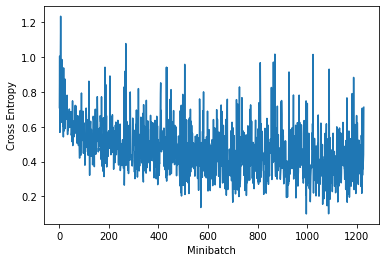

In [ ]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.savefig(os.path.join('drive','My Drive','Colab Notebooks','CS760','result','res101_epoch30_Minibatchloss.jpg'))#,dpi = 400)
plt.show()

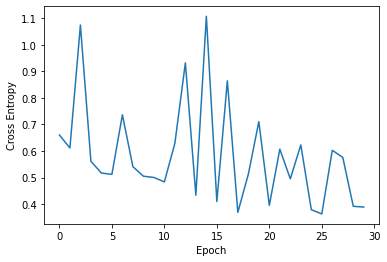

In [ ]:

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.savefig(os.path.join('drive','My Drive','Colab Notebooks','CS760','result','res101_epoch30_epochloss.jpg'))#,dpi = 400)
plt.show()